In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Getting the data

As always, let's import our last updated data.

In [2]:
from utils import load_datasets

gru_data_folder = os.path.join(parent_dir, "3_preprocessing", "output", "gru")
gru_train_set, gru_val_set, gru_test_set = load_datasets(folder=gru_data_folder)

grubert_data_folder = os.path.join(parent_dir, "3_preprocessing", "output", "grubert")
grubert_train_set, grubert_val_set, grubert_test_set = load_datasets(folder=grubert_data_folder)

# Error Analysis - Overview

We are now going to evaluate our best performing model, namely **GruBERT** in its configuration **Base Case**. In particular, we will analyze the instance trained with seed **42**, as it achieved the best performance.


We will study the errors made by the model, both in the Validation and Test Sets, by considering three perspectives:

- **Numerical Analysis**: We take a look at the frequencies with which both labels are gotten wrong, both in absolute and relative terms, and to the PR curve of the model. 
- **Visualization**: We try to visualize our dataset with dimensionality reduction techniques to understand whether the two classes tend to cluster in the embedding space.
- **Nature of wronged tweets**: We analyze the tweets that were classified wrongly, namely (a) their shift from the general distribution of words, (b) whether we can find the common elements that make one tweet confused, (c) the role of OOVs.


## Index

### **Numerical Analysis**
- Precision-Recall curves
- Confusion Matrices
- Relative error frequency

### **Visualization**
- Dimensionality reduction

### **Nature of wronged tweets**
- Word distribution shift
- Analysis of the ironic tweets gotten wrong
- Analysis of the non ironic tweets gotten wrong
- The role of OOVs


In [3]:
import torch
from metrics import DataFactory, Evaluator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Create a DataFactory
data_factory = DataFactory(
    embedding_model_path=os.path.join(parent_dir, "embedding_models/italian_word2vec_100.bin"),
    bert_model_name="m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"
)

# 2) Create an Evaluator
evaluator = Evaluator(
    data_factory=data_factory,
    device=device,
    gru_hidden_size=32,
    num_gru_layers=2,
    gru_dropout=0.2,
    embedding_dim_gru=100,
    batch_size=8,
    max_len=50
)

Importato package text_enrichment.


# Numerical Analysis
Let's take a look at the numbers.

## Precision-Recall curves

Let's take a look at the PR curves for both the validation and test set.

In [4]:
import matplotlib.pyplot as plt

parent_dir_weights = os.path.join(parent_dir, f'6_training/weights/{42}/')

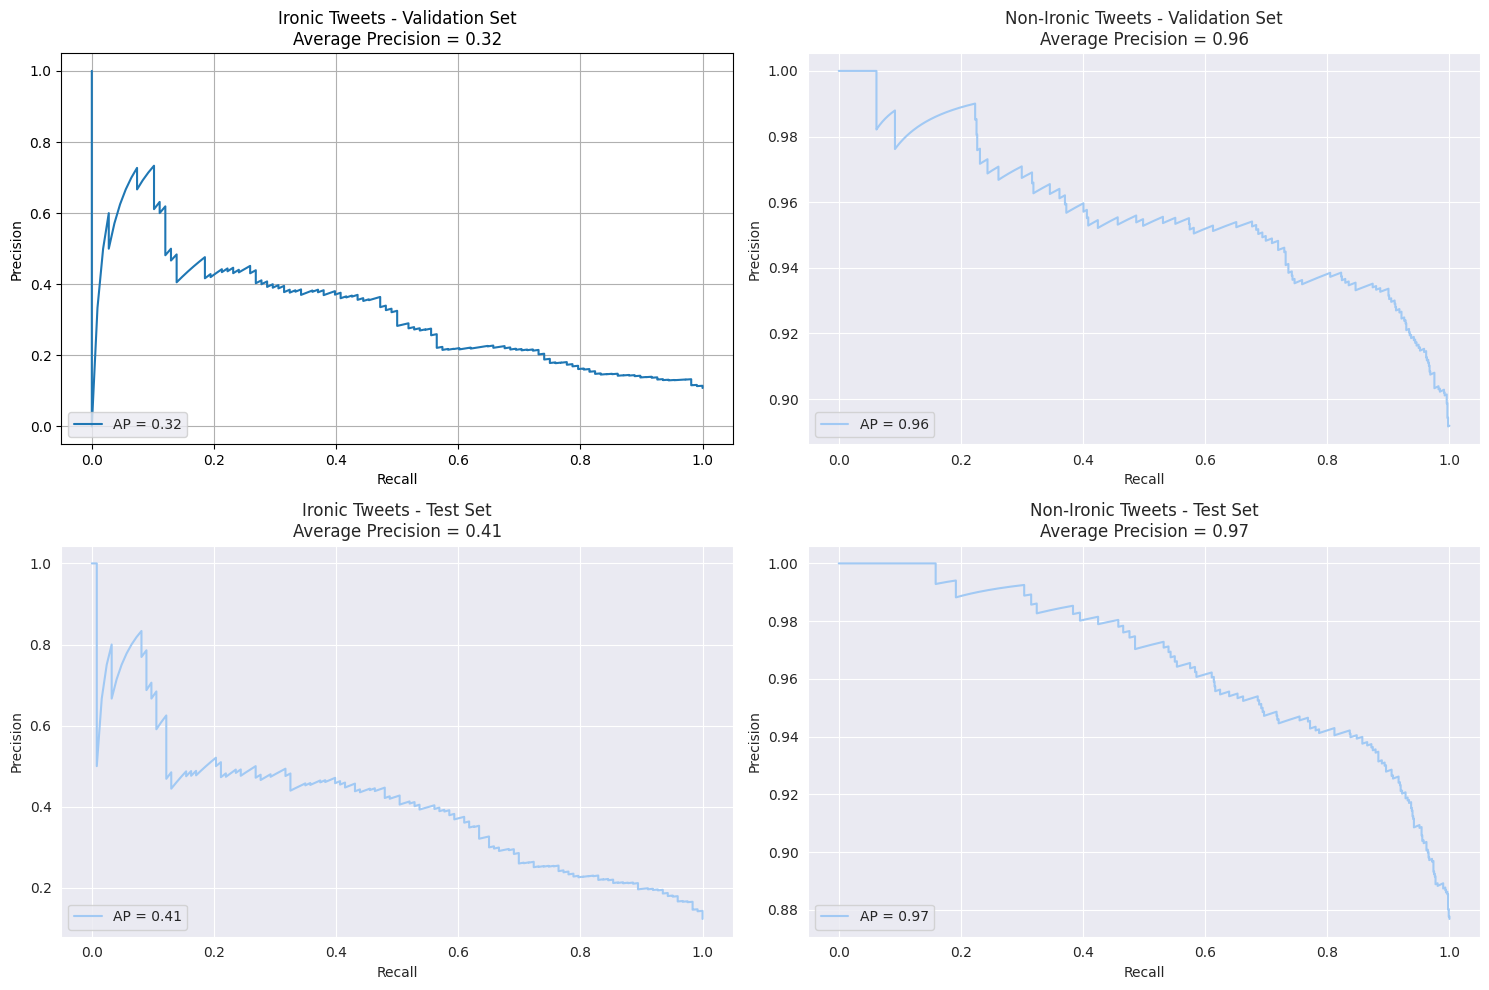

In [5]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
evaluator.plot_precision_recall_curves_over_files(
        weights_file_path="GruBERT_hashtag_enrichment.pth",
        threshold_df=grubert_val_set,
        eval_df=grubert_val_set,
        title="Ironic Tweets - Validation Set",
        parent_dir=parent_dir_weights
)

plt.subplot(2, 2, 2)
evaluator.plot_precision_recall_curves_over_files(
        weights_file_path="GruBERT_hashtag_enrichment.pth",
        threshold_df=grubert_val_set,
        eval_df=grubert_val_set,
        parent_dir=parent_dir_weights,
        title="Non-Ironic Tweets - Validation Set",
        label=0
)

plt.subplot(2, 2, 3)
evaluator.plot_precision_recall_curves_over_files(
        weights_file_path="GruBERT_hashtag_enrichment.pth",
        threshold_df=grubert_test_set,
        eval_df=grubert_test_set,
        title="Ironic Tweets - Test Set",
        parent_dir=parent_dir_weights
)

plt.subplot(2, 2, 4)
evaluator.plot_precision_recall_curves_over_files(
        weights_file_path="GruBERT_hashtag_enrichment.pth",
        threshold_df=grubert_test_set,
        eval_df=grubert_test_set,
        parent_dir=parent_dir_weights,
        title="Non-Ironic Tweets - Test Set",
        label=0
)

plt.tight_layout()
plt.show()

## Confusion Matrices

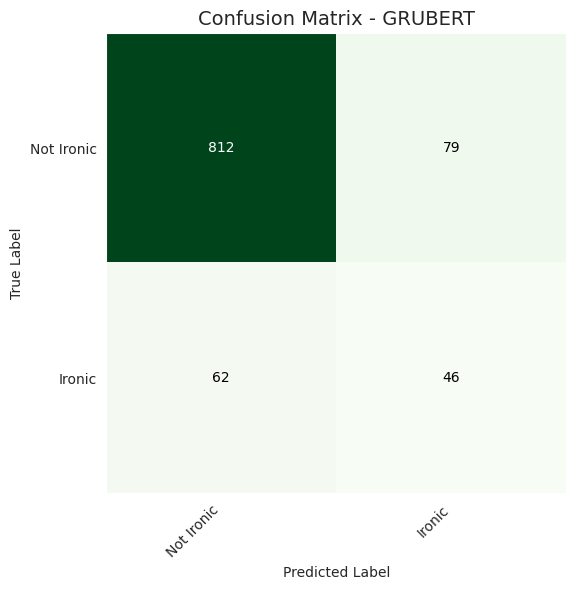

In [6]:
cm_val = evaluator.plot_confusion_matrix_for_file(
    weights_file_path="GruBERT_hashtag_enrichment.pth",
    threshold_df=grubert_val_set,
    eval_df=grubert_val_set,
    parent_dir=parent_dir_weights   
)

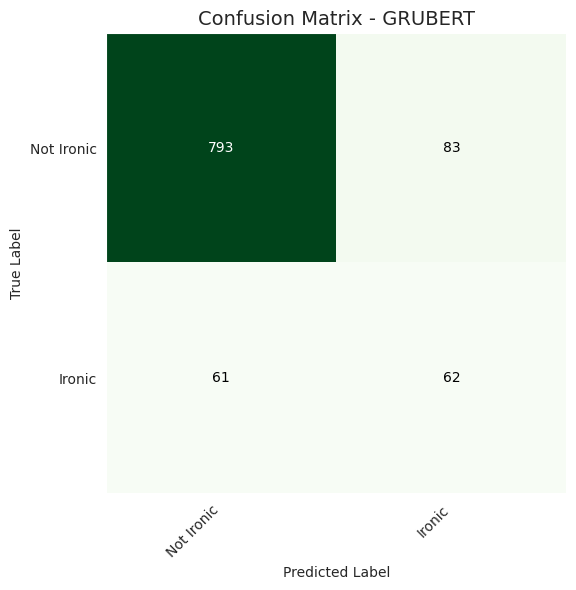

In [7]:
cm_test = evaluator.plot_confusion_matrix_for_file(
    weights_file_path="GruBERT_hashtag_enrichment.pth",
    threshold_df=grubert_val_set,
    eval_df=grubert_test_set,
    parent_dir=parent_dir_weights   
)

## Relative Error Frequency

Here is another point of view of the confusion of the model on the two sets, that highlights the percentage of each class that it got wrong.

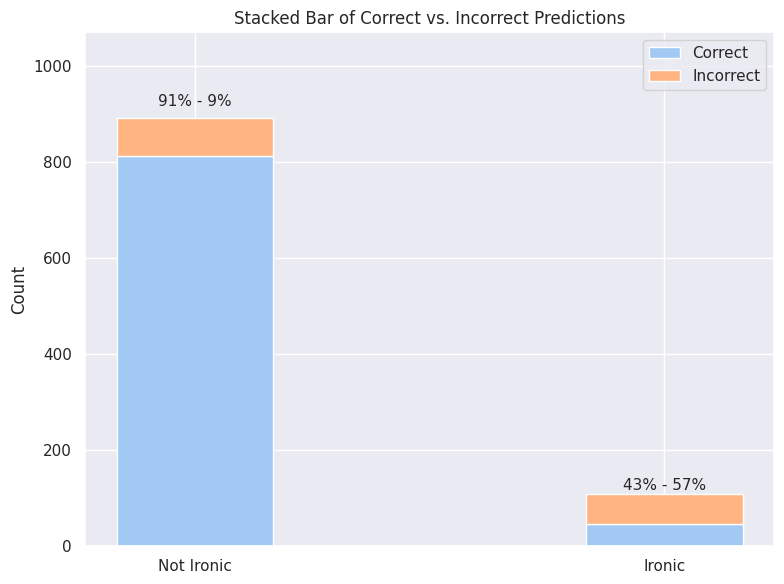

In [8]:
evaluator.plot_error_frequencies(cm_val)

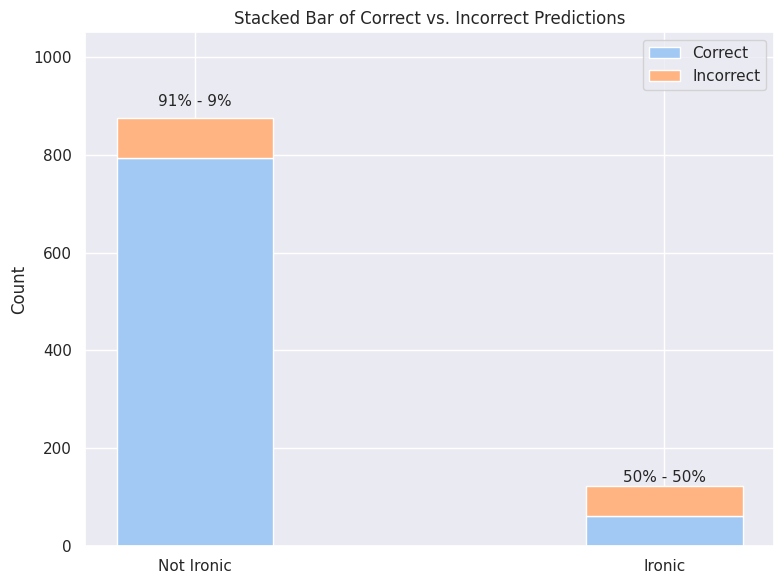

In [9]:
evaluator.plot_error_frequencies(cm_test)

# Visualizations
It's time to take a closer look.

## Introduction  
We want to visualize our data, and in order to do that, we want to **embed the sentences with our AlBERTo Encoder** and visualize their labels in a 2D space. Our hope is to see if some structure emerges and whether our model managed to learn it or not. Moreover, if we see that tweets of one of the two labels tend to cluster around a certain area, we zoom into that area and retrieve the tweets that populate it.  

## Dimensionality Reduction
We project the 768-d embeddings of our validation and test set using a combination of two well-known techniques: **Principal Component Analysis (PCA)** and **t-Distributed Stochastic Neighbor Embedding (t-SNE)**.  

**Principal Component Analysis**, or **PCA**, is a linear dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space by identifying the directions (principal components) that capture the maximum variance in the data. This method is particularly useful for simplifying data while preserving its essential patterns, and it allows to clear up noise without an excessive computational overhead.  
In fact, PCA uses Singular Value Decomposition, which, in its sci-kit learn implementation has complexity $O(n_{components}×n_{samples}×n_{features}​)$.   

**t-Distributed Stochastic Neighbor Embedding**, or **t-SNE**,  is a nonlinear dimensionality reduction method designed for the visualization of high-dimensional data. It models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are represented by nearby points and dissimilar objects are represented by distant points with high probability. In its sci-kit learn implementation, which by defaults run with an approximation technique called *Barnes-Hut*, the computational overhead is $O(n_{samples}*log(n_{samples}))$.

In particular, we procede as follows:  
1. **768D→50D [PCA]**: We project the embeddings of AlBERTo (taken using the [CLS] token) onto a 50-d vector space using PCA;
2. **50D→2D [t-SNE]**: We further project the 50 principal components extracted with PCA to a 2-d space using t-SNE.  

This is a common practice when dealing with high-dimensional, complex embeddings because it combines the strenghts of both techniques resulting in an acceptable tradeoff between the variance information given by PCA and the similarity information given by t-SNE.

## Validation Set

Embeddings shape: torch.Size([999, 768])


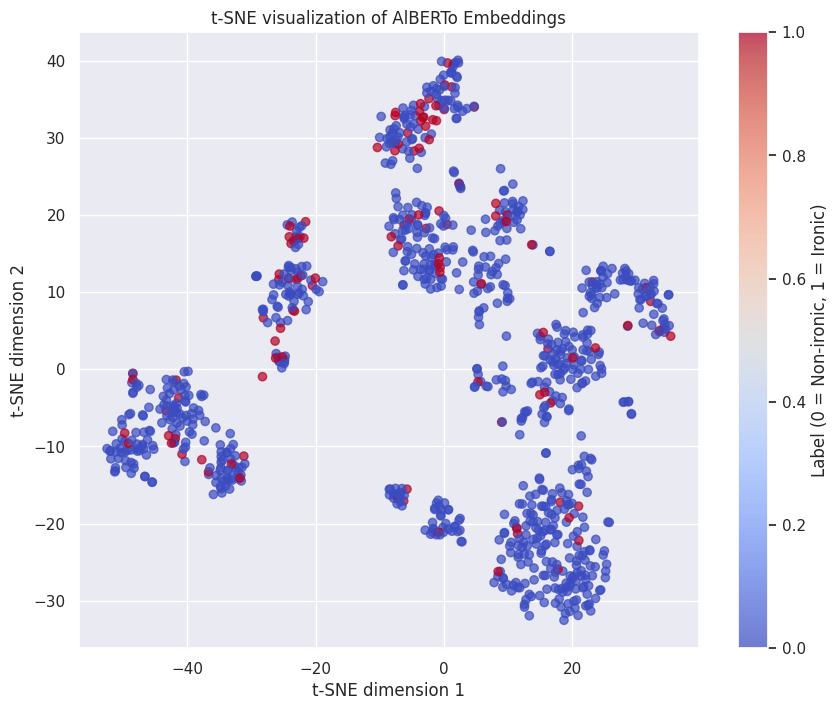

In [10]:
from plot import plot_tsne_alberto

tsne_true_out_val, _ = plot_tsne_alberto(
                            grubert_val_set, 
                            text_column="text",
                            label_column="iro",
                            batch_size=16,
                            pca_components=50,
                            tsne_components=2,
                            random_state=42,
                            return_data=True,
                        )

In the resulting plot, we notice some things:  
1. **No clear structure for ironic tweets emerges**, confirming that this task, over this dataset, is intrinsecally **hard**.
2. **A small cluster of ironic tweets** seems to be present around the point of coordinates -3, 33.
3. **Some areas are uniformally unironic**, like for the area around the point 20, -28.

### Reading the tweets in the small cluster of ironic tweets

Let's zoom into the ironic cluster, and see which tweets are present in a circle centrated in the point $(-3,33)$ and with radius $3$.

Embeddings shape: torch.Size([999, 768])


/home/francesco/Desktop/review_codice/NLP_irony/plot.py:285: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


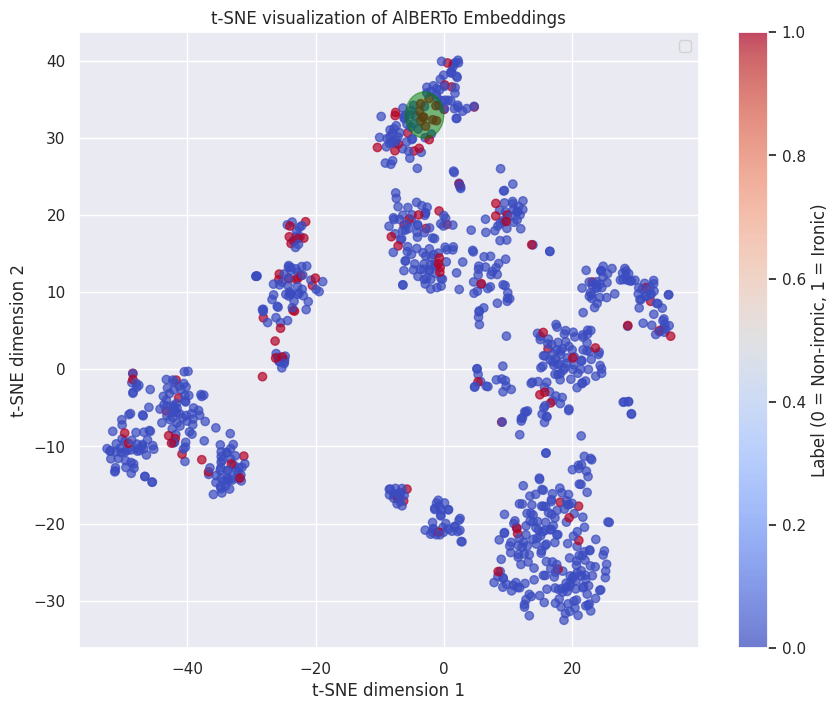

In [11]:
from plot import plot_tsne_alberto

tsne_true_out_val, _ = plot_tsne_alberto(
                            grubert_val_set, 
                            text_column="text",
                            label_column="iro",
                            batch_size=16,
                            pca_components=50,
                            tsne_components=2,
                            random_state=42,
                            return_data=True,
                            circle=(-3,33,3)
                        )

In [12]:
from plot import get_tweets_in_circle

ironic_cluster = get_tweets_in_circle(
    tsne_out=tsne_true_out_val,
    df=grubert_val_set,
    x=-3, y=33, r=3
)


Tweets inside the circle (center=(-3, 33), radius=3):
iro                                                     0
text    comunque l'immagine di mario monti come il sad...
prob                                                  0.0
Name: 72, dtype: object
---
Tweet:
comunque l'immagine di mario monti come il saddam hussein del business è fantastica
Label:
0

iro                                                     0
text    #napolitano governo monti ora. presidente non ...
prob                                                  0.0
Name: 160, dtype: object
---
Tweet:
#napolitano governo monti ora. presidente non permetta a b di trascinarci oltre nel baratro
Label:
0

iro                                                     0
text    ma non sarà che il governo #monti sarà un flop...
prob                                             0.190016
Name: 169, dtype: object
---
Tweet:
ma non sarà che il governo #monti sarà un flop come i precedenti governi tecnici?
Label:
0

iro                         

One thing that emerges is that, unsurprisingly when it comes to Tweeter and Italy's public discourse, the ironic tweets are about politics.

### Reading the tweets in auniformally unironic area

Let's take an area of uniformally unironic tweets, and see whether we can see something similar there. We pick the circle centrated in $(20, -28)$, again with radius $3$.

Embeddings shape: torch.Size([999, 768])


/home/francesco/Desktop/review_codice/NLP_irony/plot.py:285: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


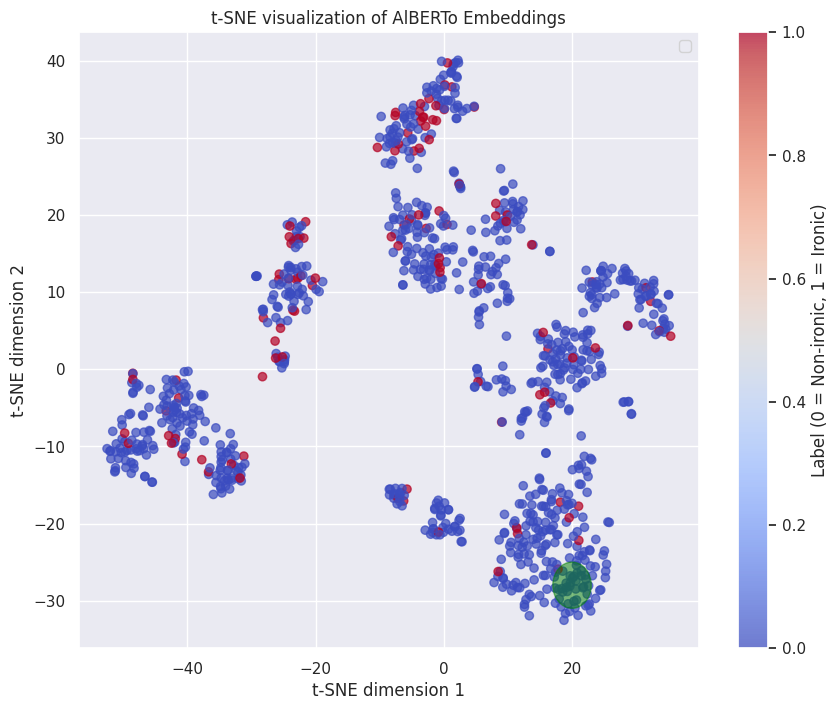

In [13]:
from plot import plot_tsne_alberto

tsne_true_out_val, _ = plot_tsne_alberto(
                            grubert_val_set, 
                            text_column="text",
                            label_column="iro",
                            batch_size=16,
                            pca_components=50,
                            tsne_components=2,
                            random_state=42,
                            return_data=True,
                            circle=(20,-28,3)
                        )

In [14]:
from plot import get_tweets_in_circle

non_ironic_cluster = get_tweets_in_circle(
    tsne_out=tsne_true_out_val,
    df=grubert_val_set,
    x=20, y=-28, r=3
)


Tweets inside the circle (center=(20, -28), radius=3):
iro                                                     0
text    insulti a mario monti sui manifesti di forza n...
prob                                                  0.0
Name: 17, dtype: object
---
Tweet:
insulti a mario monti sui manifesti di forza nuova: <url> tw
Label:
0

iro                                                     0
text    mannaia del governo monti sui tribunali abruzz...
prob                                                  0.0
Name: 69, dtype: object
---
Tweet:
mannaia del governo monti sui tribunali abruzzesi. le proposte di confindustria <url>
Label:
0

iro                                                  0
text    il governo monti parte col piede giusto: <url>
prob                                               0.0
Name: 71, dtype: object
---
Tweet:
il governo monti parte col piede giusto: <url>
Label:
0

iro                                                     0
text    italiani non esultate: mario monti e

It seems like these tweets are mostly from newspaper tweeter accounts that link their article. They are all similar in structure, with a short title and an url at the end.

### Visualizing how our model learnt

What if we used the same visualization but labeled the points with the logits outputed by the model, instead of the Ground Truth? We would get a visual representation of what the model learnt, and see if it chromatically fits with the plot we have already seen.

In [15]:
model_class, config_name, y_eval_true, y_eval_pred, best_thr = evaluator._get_predictions_for_file(
        file_name="GruBERT_hashtag_enrichment.pth",
        threshold_df = grubert_val_set,
        eval_df = grubert_val_set,
        parent_dir = parent_dir_weights
    )

In [16]:
grubert_val_set["prediction"] = y_eval_pred

Embeddings shape: torch.Size([999, 768])


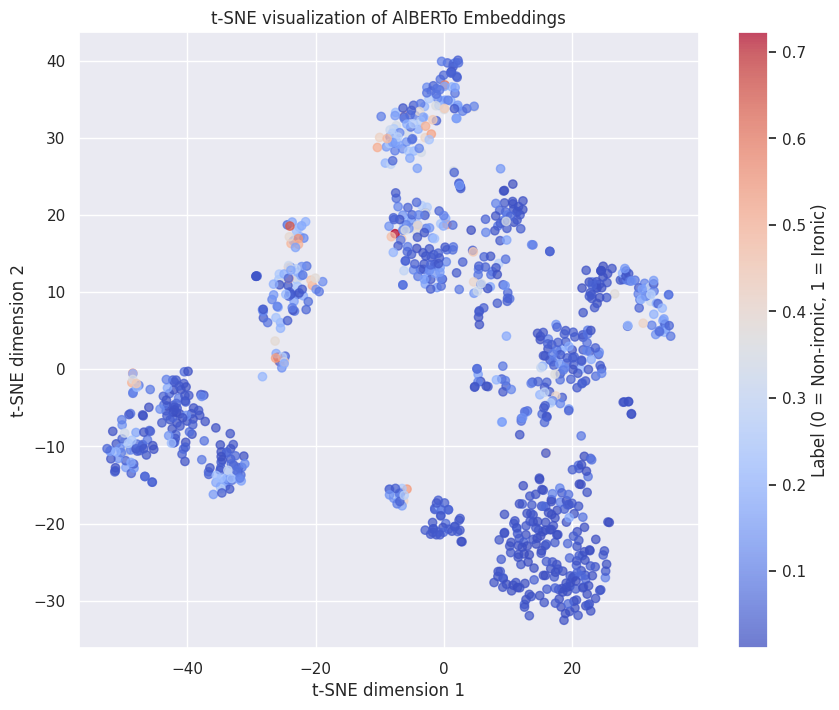

In [17]:
tsne_pred_out_val, _ = plot_tsne_alberto(
                            grubert_val_set, 
                            text_column="text",
                            label_column="prediction",
                            batch_size=16,
                            pca_components=50,
                            tsne_components=2,
                            random_state=42,
                            return_data=True
                        )

It seems like we can state the following:  
1. The area that we highlighted as the only one where some sort of ironic cluster had formed is indeed the only one that the model (tenderly, to be honest) colored in red.  
2. In all other areas, except for some isolated examples, the model seems to be overwhelmed by the negatives and thus to have learnt the majority classification.

### The word distribution in the two analyzed clusters

Let's take a look at the wordcloud that describes the distribution of words in the two clusters that we have seen (the ironic one and the completely unironic one).  
For visualization purpuses, other than removing stopwords, we cared to remove the intersection of the two sets of words, so that only the ones that often appear exclusively in one of the two are showed.

In [18]:
from plot import wordcloud
from utils import intersection_tokens

remove_words = intersection_tokens(ironic_cluster, non_ironic_cluster)

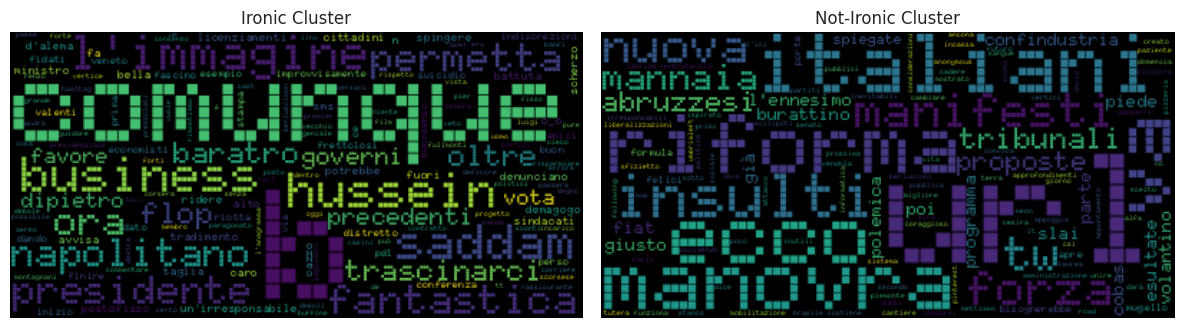

In [19]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
wordcloud(ironic_cluster, is_subplot=True, parent_dir=parent_dir, remove_words=remove_words, custom_title='Ironic Cluster')
plt.subplot(1,2,2)
wordcloud(non_ironic_cluster, is_subplot=True, parent_dir=parent_dir, remove_words=remove_words, custom_title='Not-Ironic Cluster')

We get that:  
- Ironic tweets are characterized by the presence of words that contain, explicitly or not, some sort of personal judgement, like *estremista*, *violento* or *offensivo*. Moreover, this subjectivity seem to have a negative tone and view of the world in general, as we can see from words like *baratro*, *flop*, *irresponsabile*, or again *estremista* and *violento*.
- Unironic tweets are also monopolized by politics, but the tone seems to be more journalistic and neutral. The high presence of newspapers tweets is  indicated by the gigantic *url* that is often a link to the complete article referred to by the tweet.

## Test Set

Embeddings shape: torch.Size([999, 768])


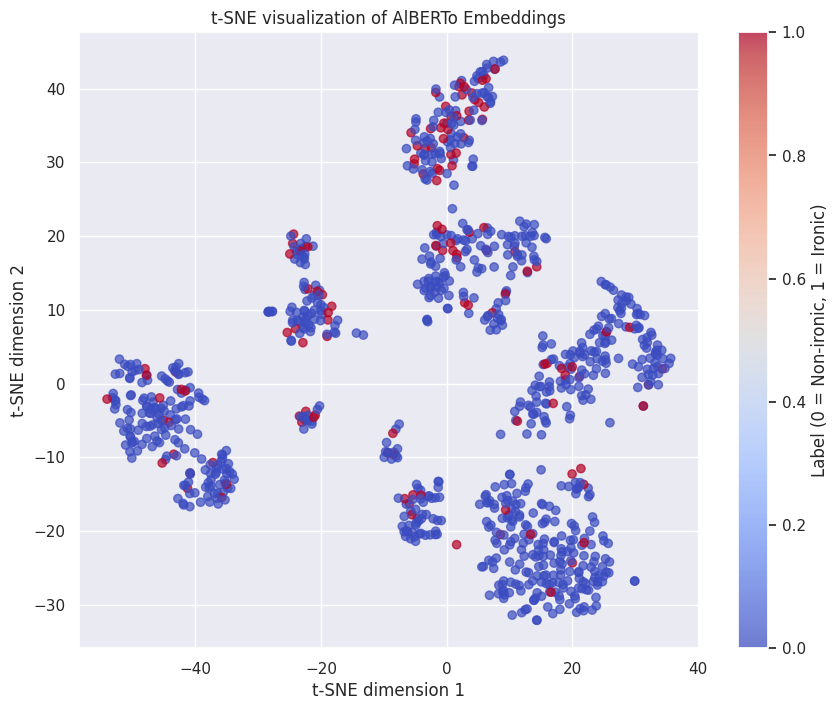

In [20]:
from plot import plot_tsne_alberto

tsne_true_out_test, _ = plot_tsne_alberto(
                            grubert_test_set, 
                            text_column="text",
                            label_column="iro",
                            batch_size=16,
                            pca_components=50,
                            tsne_components=2,
                            random_state=42,
                            return_data=True,
                        )

In the resulting plot, we notice some things:  
1. Like in the validation set, **no clear structure for ironic tweets emerges**, confirming once again that this task, over this dataset, is intrinsecally **hard**.
2. **A group of tweets for which the label distribution looks more balanced** has formed in the highest cloud of points.
3. Again, **the rest of the plot is pretty much all blue**, with some red dots here and there. We'll take a look at one of these groups.

### Reading the tweets in the messy area

Let's zoom into the ironic cluster, and see which tweets are present in a circle centrated in the point $(0,36)$ and with radius $12$, as it is the one where the ironic tweets seem to be a lot.

Embeddings shape: torch.Size([999, 768])


/home/francesco/Desktop/review_codice/NLP_irony/plot.py:285: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


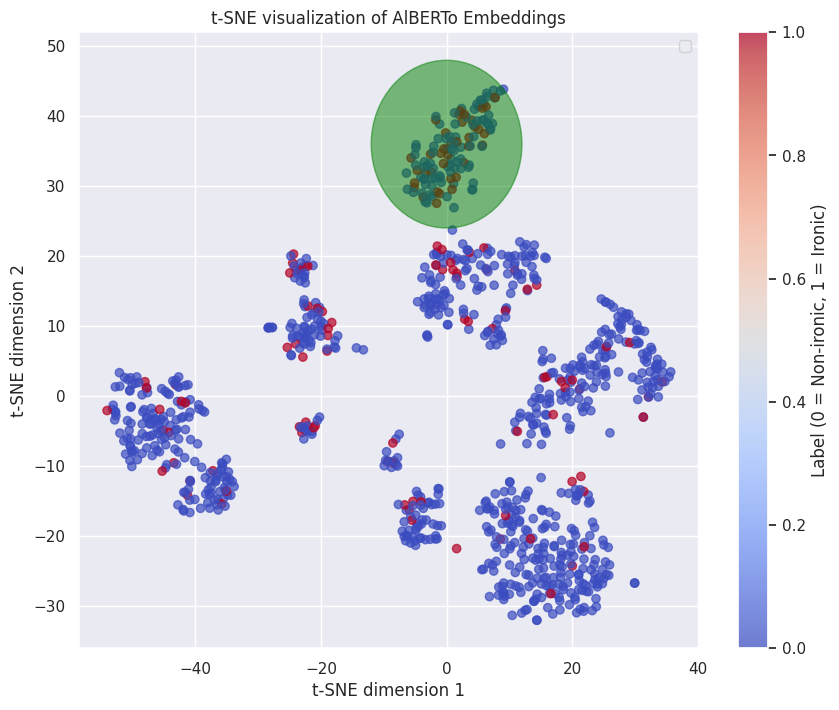

In [21]:
from plot import plot_tsne_alberto

tsne_true_out_test, _ = plot_tsne_alberto(
                            grubert_test_set, 
                            text_column="text",
                            label_column="iro",
                            batch_size=16,
                            pca_components=50,
                            tsne_components=2,
                            random_state=42,
                            return_data=True,
                            circle=(0,36,12)
                        )

In [22]:
model_class, config_name, y_eval_true, y_eval_pred, best_thr = evaluator._get_predictions_for_file(
        file_name="GruBERT_hashtag_enrichment.pth",
        threshold_df = grubert_val_set,
        eval_df = grubert_test_set,
        parent_dir = parent_dir_weights
    )

In [23]:
grubert_test_set["prediction"] = y_eval_pred

In [24]:
from plot import get_tweets_in_circle

ironic_cluster = get_tweets_in_circle(
    tsne_out=tsne_true_out_test,
    df=grubert_test_set,
    x=-0, y=36, r=12
)


Tweets inside the circle (center=(0, 36), radius=12):
iro                                 0
text          ma basta con sto caldo.
prob                              0.0
prediction                   0.139389
Name: 14, dtype: object
---
Tweet:
ma basta con sto caldo.
Label:
0

iro                                                           0
text          da grandi poteri derivano grandi responsabilit...
prob                                                        0.0
prediction                                              0.15351
Name: 23, dtype: object
---
Tweet:
da grandi poteri derivano grandi responsabilità, illustre professor monti. now save us!
Label:
0

iro                                                           1
text          iacopino regala tessera da giornalista a mario...
prob                                                        0.0
prediction                                             0.267536
Name: 25, dtype: object
---
Tweet:
iacopino regala tessera da giornalista a mar

These tweets are EXTREMELY hard to classify. They are almost all difficult to classify in one sense or the other, even for a human labeler.  

We see non-ironic tweets that look like ones, like:  

**Tweet**: #miocuggino mi ha detto che mario monti da bambino una volta è morto. #oramonti  
**Label**: 0  
**Predicted**: 0.628  

and ironic tweets for which the irony is really subtle, or maybe is solely based on some pop culture common fact.  
For instance, in the following tweet the irony comes from congratulating the new prime minister Mario Monti, a well-known economist and former board member of an italian bank, and at the same time making a quote about the fact that being in that kind of position is a crime:  

**Tweet**: e' più criminale fondare una banca che rapinarla (cit. b.brecht) tanti auguri al nuovo governo #monti   
**Label**: 1  
**Predicted**: 0.249  



### Reading the tweets in auniformally unironic area

Let's take an area of uniformally unironic tweets, and see whether we can see something similar there. We pick the circle centrated in $(0, 12)$, again with radius $3$.

Embeddings shape: torch.Size([999, 768])


/home/francesco/Desktop/review_codice/NLP_irony/plot.py:285: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


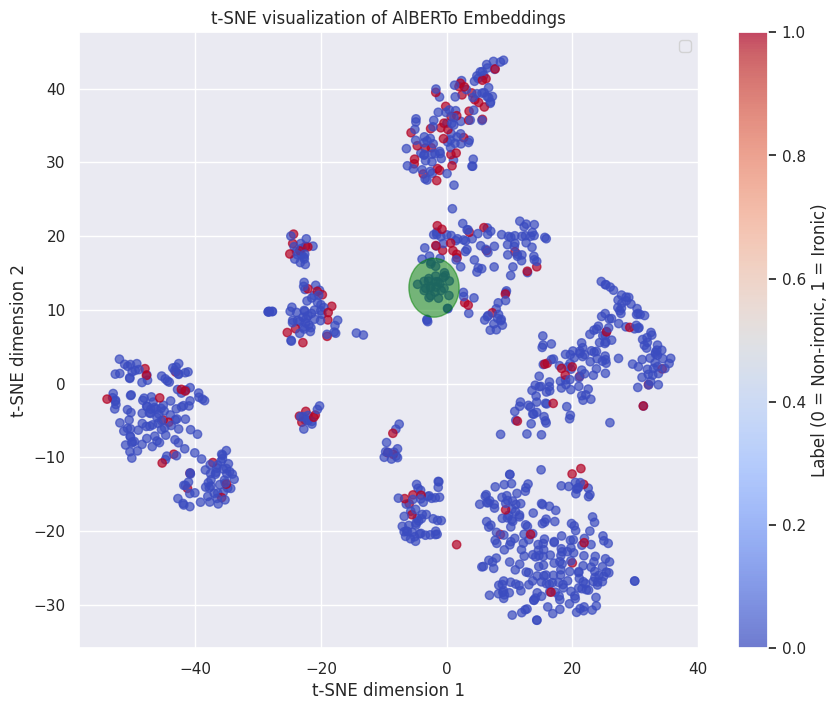

In [25]:
from plot import plot_tsne_alberto

tsne_true_out_test, _ = plot_tsne_alberto(
                            grubert_test_set, 
                            text_column="text",
                            label_column="iro",
                            batch_size=16,
                            pca_components=50,
                            tsne_components=2,
                            random_state=42,
                            return_data=True,
                            circle=(-2,13,4)
                        )

In [26]:
from plot import get_tweets_in_circle

non_ironic_cluster = get_tweets_in_circle(
    tsne_out=tsne_true_out_test,
    df=grubert_test_set,
    x=-2, y=12, r=4
)


Tweets inside the circle (center=(-2, 12), radius=4):
iro                                                           0
text          forza #grillo , mandiamoli tutti a casa stà ma...
prob                                                   0.053218
prediction                                             0.040253
Name: 80, dtype: object
---
Tweet:
forza #grillo , mandiamoli tutti a casa stà massa di ladri e ipocriti di politici. #m5s
Label:
0

iro                                                           0
text          #grillo ha detto di essere contrario alla citt...
prob                                                   0.053218
prediction                                             0.027076
Name: 137, dtype: object
---
Tweet:
#grillo ha detto di essere contrario alla cittadinanza per i bambini stranieri che nascono in italia. questo ci aiuta a capire meglio grillo
Label:
0

iro                                                           0
text          #grillo prende i voti della lega. s

We found the Beppe Grillo island! Ironically enough, nobody jokes around here. In fact, all tweets in this group are easily non ironic, as their tone is not objective but still very serious, and sometimes angry.

### Visualizing how our model learnt

What if we used the same visualization but labeled the points with the logits outputed by the model, instead of the Ground Truth? We would get a visual representation of what the model learnt, and see if it chromatically fits with the plot we have already seen.

Embeddings shape: torch.Size([999, 768])


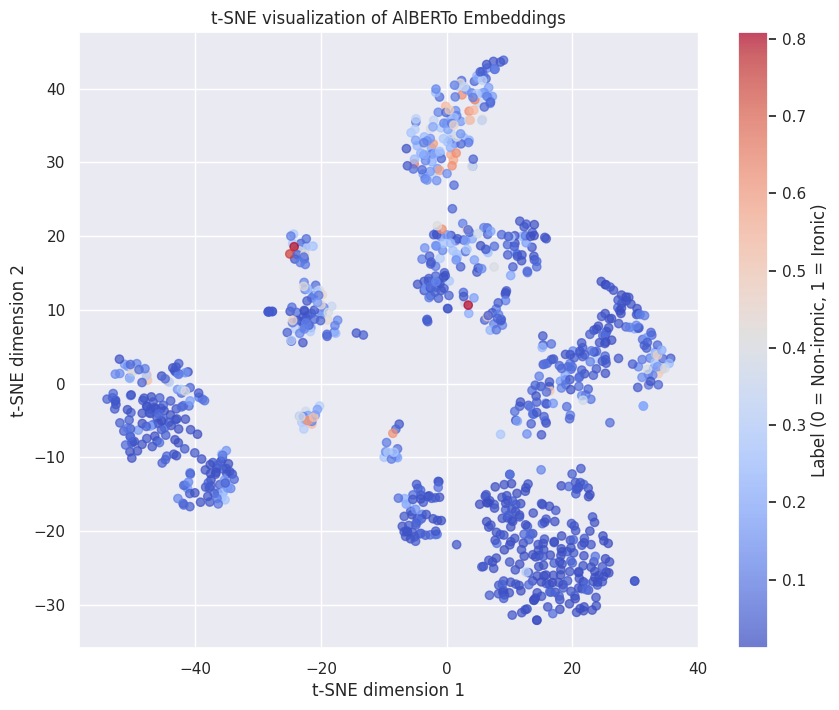

In [27]:
tsne_pred_out_test, _ = plot_tsne_alberto(
                            grubert_test_set, 
                            text_column="text",
                            label_column="prediction",
                            batch_size=16,
                            pca_components=50,
                            tsne_components=2,
                            random_state=42,
                            return_data=True
                        )

Again, we see a chromatic reseamblance of what we saw with the hard labels, and again there are some areas where blue has completely taken over.  
Overall, given the difficulty of the task, it's a good view.

### The word distribution in the two analyzed clusters

Let's take a look at the wordcloud that describes the distribution of words in the two clusters that we have seen (the ironic one and the completely unironic one).  
For visualization purpuses, other than removing stopwords, we cared to remove the intersection of the two sets of words, so that only the ones that often appear exclusively in one of the two are showed.

In [28]:
from plot import wordcloud
from utils import intersection_tokens

remove_words = intersection_tokens(ironic_cluster, non_ironic_cluster)

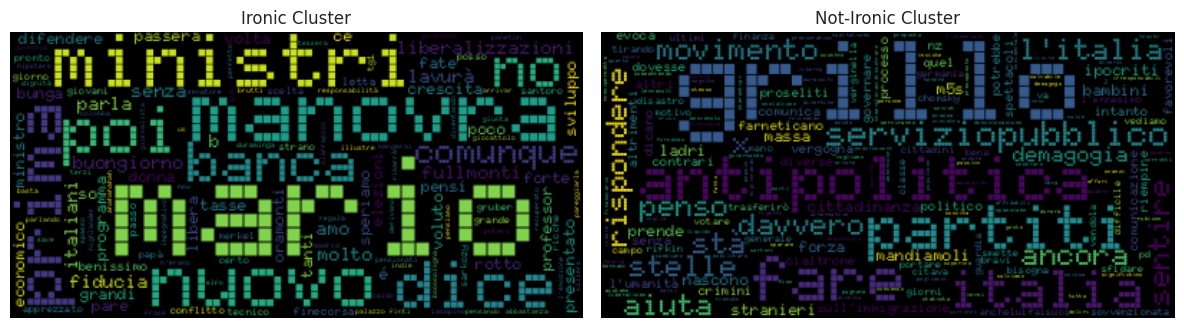

In [29]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
wordcloud(ironic_cluster, is_subplot=True, parent_dir=parent_dir, remove_words=remove_words, custom_title='Ironic Cluster')
plt.subplot(1,2,2)
wordcloud(non_ironic_cluster, is_subplot=True, parent_dir=parent_dir, remove_words=remove_words, custom_title='Not-Ironic Cluster')

The two clouds give us an idea of the object of the tweets inside these clusters (respectively Mario Monti and Beppe Grillo), rather than their irony label. 

# All errors, printed  
We are left with one thing: reading every mistaken tweet.

## Validation Set

### True: Ironic; Predicted: Not-Ironic

In [30]:
evaluator.print_mistaken_tweets(
    true_label=1,
    weights_file_path="GruBERT_hashtag_enrichment.pth",
    threshold_df=grubert_val_set,
    eval_df=grubert_val_set, 
    parent_dir=parent_dir_weights
)


Mistaken tweets where true label = 1 but predicted = 0:
ieri a sempione vlada mi ha gridato stop!!!! e io come una cogliona ho iniziato a cantare freeze dei block b.kpop cosa mi hai fatto.
su rai1 la partita dell'italia non è criptata per gli utenti sky: il primo vero effetto del governo monti?
'l'italia riparte dalla buona scuola' prrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr....!!!'
<mention> c'è anche mario monti burns
al tg1 stanno definendo i soliti idioti cantanti .... ....no, non riesco a fare nemmeno una battuta è già abbastanza ridicolo così!
la hit del 2012 e' fuori. nacho, pakos e uncle j come mario monti se non la pompi non apprezzi il bello <url>
#pascale amore vero? il mondo intero chiede certezze.
bisogna dirlo: questi del vatic_ano sono davvero in gamba. salutano con gioia il governo monti perché e' il loro... <url>
mario monti chi? <url> seeee, vabbè! goldman sachs de che? <url>
<mention> bisognerebbe pagare i politici con

### True: Not-Ironic; Predicted: Ironic

In [31]:
evaluator.print_mistaken_tweets(
    true_label=0,
    weights_file_path="GruBERT_hashtag_enrichment.pth",
    threshold_df=grubert_val_set,
    eval_df=grubert_val_set, 
    parent_dir=parent_dir_weights
)


Mistaken tweets where true label = 0 but predicted = 1:
fund raising: oltre 120000 euro reperiti in 2 anni, di cui quasi 70000 direttamente a #ic15bologna anche questo è #labuonascuola
governo monti, passera, profumo: mi sembra il golpe delle banche ma forse sbaglio...
<mention> io ho i genitori campani ahah (tutti parenti compresi) xd
la manovra non esaurisce i provvedimenti del governo monti. è così difficile da capire? #monti #manovra #wakeupitaly
<mention> io ancora rutto la ricotta fritta di mezz'ora fa!
comunque l'immagine di mario monti come il saddam hussein del business è fantastica
<mention> mika: willy willy willy? questo è inglese? volio un cazo cazo cazo? non riesco a dimenticare 'sta scena, oddio hahahahahaah…
#camusso: "se #governo #monti pensa di aver chiuso il capitolo previdenza si è sbagliato, è ancora aperto".
<mention> grazie...mi serviva una mappa! ;dd lool con il diario non ci capisco un corno.
“i bambini entrano a scuola come punti interrogativi e la lasciano c

## Test Set

### True: Ironic; Predicted: Not-Ironic

In [32]:
evaluator.print_mistaken_tweets(
    true_label=1,
    weights_file_path="GruBERT_hashtag_enrichment.pth",
    threshold_df=grubert_val_set,
    eval_df=grubert_test_set, 
    parent_dir=parent_dir_weights
)


Mistaken tweets where true label = 1 but predicted = 0:
qual è la parola che usi più spesso? — scuola. ahah ci sei cascato? x'd <url>
<mention> <mention> dite tutti i docenti di cui la buona scuola ha bisogno' e come capirete chi la rende buona e chi no? simpatia?
ciarrapico: comunque sa quale è il problema del governo monti? quale, senatore? che so' troppo brutti #ahahahahah
ripristinando l'ici sulla prima casa, il governo monti riesce nell'impresa di cancellare la sola cosa positiva fatta da berlusconi. chapeau.
#monti #chetempochefa l'atteggiamento 'mentale' del governo monti? nessun tabù! (aiiuutooo)
e comunque <mention> alla lezione di sillabazione de #labuonascuola era assente <url>
dal buono-scuola alla buona scuola renziana: buone ragioni per lo sciopero <url> #10_ottobre #quota_96 #sciopero
d'alema: il governo monti è una nostra vittoria, ci lavoravamo da un anno. con politici come lui nun c'è bisogno del centrodestra.
mario monti nominato europeo dell'anno . <url> e gli altr

### True: Not-Ironic; Predicted: Ironic

In [33]:
evaluator.print_mistaken_tweets(
    true_label=0,
    weights_file_path="GruBERT_hashtag_enrichment.pth",
    threshold_df=grubert_val_set,
    eval_df=grubert_test_set, 
    parent_dir=parent_dir_weights
)


Mistaken tweets where true label = 0 but predicted = 1:
<mention> ci pensa #grillo a farsi le vacanze in yacht dopo aver predicato bene.
<mention> mario monti? preferisco capperi e acciughe! (il trota)
a porta a porta il #pd si surriscalda con i suoi difendendo il governo #monti. e questi avrebbero dovuto governarci al posto di #berlusconi?
con una mano si da e con l'altra si leva e la buona scuola va avanti come può. se si vuole risparmiare bisogna decentrare, ma ancora niente
<mention> oppure il patologo sei tu e osservi tutti sti cadaveri
45. cosa pensi del governo monti? .....
<mention> #serviziopubblico si capirà solo quando si toccherà il fondo ...tutti però
c'è un elfo nel governo #monti e sta parlando ora! è perfetto per #ilsignoredeglianelli
<mention> i 150.000 insegnanti che #labuonascuola vuole assumere hanno tutto 'il merito'e hanno superato più concorsi! #finoallultimoidoneo
a mario monti arrivano richieste di incontri un po' da tutti. gli unici che non si sono fatti anco

asse x -> lunghezza
asse y -> f1 score

asse x -> numero oov
asse y -> f1 score